Import packages

In [6]:
import numpy as np
import pandas as pd
import glob
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from xml.etree import ElementTree
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

columns = ['DATE', 
           'CUST_ID', 
           'DEVICE', 
           'P/C', 
           '製令編碼', 
           'vendor', 
           'Dut', 
           'PROCESS_ID', 
           '送修時間', 
           'STATUS', 
           'NEW針長', 
           'NOW針長', 
           '已用針長', 
           '送修時已使用TD', 
           '累積TD', 
           '總使用TD', 
           'PM TD', 
           'MTBF達成率', 
           'MTBF判定', 
           '送修原因', 
           '送修備註', 
           '維修成功率']

Read file, sort rows by date, add neccesary columns

In [7]:
df = pd.read_excel('data/MTBF-CP/mtbf_more.xlsx', usecols=[ '送修時間',
                                                            'STATUS',
                                                            'P/C',
                                                            'CUST_ID',
                                                            'vendor',
                                                            'Dut',
                                                            'PROCESS_ID',
                                                            'NEW針長', 
                                                            'NOW針長', 
                                                            '已用針長',
                                                            'MTBF判定',
                                                            '維修前針徑(UM)', 
                                                            '維修前共面(UM)', 
                                                            '維修前針長(MILS)', 
                                                            '維修後針徑(UM)', 
                                                            '維修後共面(UM)', 
                                                            '維修後針長(MILS)',
                                                            '送修時已使用TD'])
df['送修時間'] = df['送修時間'].apply(pd.to_datetime)
df = df.sort_values(by='送修時間', ascending=True)
df = df.reset_index(drop=True)


df['上次維修後針徑(UM)'] = np.nan
df['上次維修後共面(UM)'] = np.nan
df['上次維修後針長(MILS)'] = np.nan

df

,CUST_ID,P/C,vendor,Dut,PROCESS_ID,送修時間,STATUS,NEW針長,NOW針長,已用針長,...,MTBF判定,維修前針徑(UM),維修前共面(UM),維修前針長(MILS),維修後針徑(UM),維修後共面(UM),維修後針長(MILS),上次維修後針徑(UM),上次維修後共面(UM),上次維修後針長(MILS)
0,T44,JB174S07,MPI,1,CP3,2022-05-01 07:52:33,內修(舊),11.3,8.1,3.2,...,FAIL,17.0,9.0,8.07,18.0,8.0,8.07,NaN,NaN,NaN
1,T84,JB1W8S02,MPI,1,CP2+CP3,2022-05-01 08:41:27,外修(舊),10.6,5.4,5.2,...,FAIL,17.0,4.0,5.43,17.0,4.0,5.43,NaN,NaN,NaN
2,T44,JB1P3S11,MPI,1,CP2+CP3,2022-05-01 08:59:24,定期PM,11.7,8.5,3.2,...,PASS,17.0,12.0,8.54,19.4,4.1,8.34,NaN,NaN,NaN
3,T32A,JB2JYS14,MPI,2,CP1,2022-05-01 09:24:30,內修(舊),11.5,5.9,5.6,...,FAIL,22.0,7.0,5.90,19.0,7.0,5.90,NaN,NaN,NaN
4,T44,TB1N3S45,SDA,1,CP2,2022-05-01 10:11:54,外修(舊),12.5,6.7,5.8,...,PASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7457,T44,JB1H5S05,MPI,1,CP1,2023-07-31 01:05:56,內修(舊),11.7,11.1,0.5,...,FAIL,18.0,9.0,11.25,18.0,9.0,11.25,NaN,NaN,NaN
7458,T84,VB224S05,MPI,2,CP1,2023-07-31 01:25:04,定期PM,11.9,7.3,4.6,...,PASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7459,T44,JB6H1S09,MPI,6,CP1,2023-07-31 01:29:47,內修(舊),11.6,10.2,1.5,...,FAIL,17.0,23.0,10.15,17.0,8.7,9.76,NaN,NaN,NaN
7460,T44,VB1AGS08,MPI,1,CP5,2023-07-31 01:41:33,內修(舊),11.7,11.7,0.0,...,FAIL,15.0,5.0,11.69,15.0,6.3,11.65,NaN,NaN,NaN


History of a specific P/C

In [4]:
df.loc[df['P/C'] == 'JB174S07', [  'P/C',
                                   '送修時間', 
                                   'CUST_ID',
                                   'vendor',
                                   'Dut',
                                   'PROCESS_ID',
                                   'NEW針長', 
                                   'NOW針長', 
                                   '已用針長', 
                                   '維修前針徑(UM)', 
                                   '維修前共面(UM)', 
                                   '維修前針長(MILS)', 
                                   '維修後針徑(UM)', 
                                   '維修後共面(UM)', 
                                   '維修後針長(MILS)',
                                   '送修時已使用TD',
                                   '上次維修後針徑(UM)', 
                                   '上次維修後共面(UM)', 
                                   '上次維修後針長(MILS)']]

,P/C,送修時間,CUST_ID,vendor,Dut,PROCESS_ID,NEW針長,NOW針長,已用針長,維修前針徑(UM),維修前共面(UM),維修前針長(MILS),維修後針徑(UM),維修後共面(UM),維修後針長(MILS),送修時已使用TD,上次維修後針徑(UM),上次維修後共面(UM),上次維修後針長(MILS)
0,JB174S07,2022-05-01 07:52:33,T44,MPI,1,CP3,11.3,8.1,3.2,17.0,9.0,8.07,18.0,8.0,8.07,87444,NaN,NaN,NaN
277,JB174S07,2022-05-14 11:30:58,T44,MPI,1,CP3,11.3,8.1,3.2,19.0,11.0,8.07,19.0,11.0,8.07,20875,NaN,NaN,NaN
2957,JB174S07,2022-10-22 15:12:22,T44,MPI,1,CP3,11.3,7.7,3.5,17.0,17.0,7.71,17.0,7.0,7.48,190073,NaN,NaN,NaN
5933,JB174S07,2023-05-08 01:39:34,T44,MPI,1,CP3,11.3,7.4,3.9,18.0,18.5,7.40,18.3,5.3,7.04,127736,NaN,NaN,NaN
6829,JB174S07,2023-06-26 04:27:07,T44,MPI,1,CP3,11.3,5.1,6.1,18.0,22.5,5.11,19.0,6.0,4.88,239875,NaN,NaN,NaN
6958,JB174S07,2023-07-03 17:27:50,T44,MPI,1,CP3,11.3,4.8,6.4,19.4,9.8,4.84,19.0,4.5,4.05,36060,NaN,NaN,NaN


Shift the columns of 維修後 by 1 down and paste to 上次維修後

In [5]:
for pc in df['P/C'].value_counts().index:
        
    df.loc[df['P/C'] == pc, [ '上次維修後針徑(UM)', 
                              '上次維修後共面(UM)', 
                              '上次維修後針長(MILS)']] = \
    df.loc[df['P/C'] == pc, [ '維修後針徑(UM)', 
                              '維修後共面(UM)', 
                              '維修後針長(MILS)']].shift(1).values

Drop the Null values and remove rows with STATUS=='定期PM'

In [136]:
df = df.dropna()
df = df.loc[(df['STATUS'] != '定期PM') & (df['送修時已使用TD'] > 100000)]

The difference of 上次維修後針長 & NEW針長

In [137]:
df['上次已使用針長(MILS)'] = df['NEW針長'] - df['上次維修後針長(MILS)']

In [138]:
df.head()

,CUST_ID,P/C,vendor,Dut,PROCESS_ID,送修時間,STATUS,NEW針長,NOW針長,已用針長,...,維修前針徑(UM),維修前共面(UM),維修前針長(MILS),維修後針徑(UM),維修後共面(UM),維修後針長(MILS),上次維修後針徑(UM),上次維修後共面(UM),上次維修後針長(MILS),上次已使用針長(MILS)
122,A88A,TC2QTS26,Univance,2,CP1,2022-05-07 12:47:50,內修(舊),12.0,6.8,5.2,...,22.0,5.0,6.77,22.4,5.0,6.77,23.0,7.0,6.96,5.04
172,T32A,JB2JYS14,MPI,2,CP1,2022-05-09 21:21:22,內修(舊),11.5,5.2,6.3,...,21.0,25.0,5.23,21.0,6.3,5.07,19.0,7.0,5.90,5.60
259,T84,VB107S02,MPI,1,CP3+CP4,2022-05-13 12:34:45,內修(舊),11.8,4.4,7.4,...,21.8,36.0,4.44,24.0,18.0,4.25,22.0,19.5,5.03,6.77
268,T32A,JB2JYS13,MPI,2,CP1,2022-05-13 17:30:00,內修(舊),11.7,5.4,6.3,...,15.0,16.0,5.43,18.0,10.0,5.23,19.0,8.0,5.55,6.15
278,T32A,JB2JYS17,MPI,2,CP1,2022-05-14 11:48:02,內修(舊),11.7,10.4,1.4,...,18.0,25.0,10.35,16.0,12.0,10.07,15.5,10.0,11.09,0.61


In [140]:
use_cols = ['CUST_ID',
            'vendor',
            'Dut',
            'PROCESS_ID',
            'NEW針長',
            '上次維修後針徑(UM)',
            '上次維修後共面(UM)',
            '上次維修後針長(MILS)',
            '上次已使用針長(MILS)',
            '送修時已使用TD']

Map Categorical Features to a numerical value

In [141]:
# Customer ID
cust_id_map = {name:n for name, n in zip(df['CUST_ID'].value_counts().index, list(range(len(df['CUST_ID'].value_counts()))))}
df['CUST_ID'] = df['CUST_ID'].map(cust_id_map)

# Vendor
vendor_map = {name:n for name, n in zip(df['vendor'].value_counts().index, list(range(len(df['vendor'].value_counts()))))}
df['vendor'] = df['vendor'].map(vendor_map)

# Process ID
process_id_map = {name:n for name, n in zip(df['PROCESS_ID'].value_counts().index, list(range(len(df['PROCESS_ID'].value_counts()))))}
df['PROCESS_ID'] = df['PROCESS_ID'].map(process_id_map)

# Dut
df['Dut'] = df['Dut'].replace('C', 5)
df['Dut'] = df['Dut'].replace('G', 7)
df['Dut'] = df['Dut'].astype('int')

Change all value to numerical

In [142]:
# Change all value to numerical
df['NEW針長'] = df['NEW針長'].astype('float')
df['上次維修後針徑(UM)'] = df['上次維修後針徑(UM)'].astype('float')
df['上次維修後共面(UM)'] = df['上次維修後共面(UM)'].astype('float')
df['上次維修後針長(MILS)'] = df['上次維修後針長(MILS)'].astype('float')
df['送修時已使用TD'] = df['送修時已使用TD'].astype('int')

In [143]:
data = df[use_cols]
data.columns = ['CUST_ID',
              'vendor',
              'Dut',
              'PROCESS_ID',
              'NEWL',
              'R',
              'M',
              'FL',
              'NEWL-FL',
              'TD']
data

,CUST_ID,vendor,Dut,PROCESS_ID,NEWL,R,M,FL,NEWL-FL,TD
122,1,2,2,0,12.0,23.0,7.0,6.96,5.04,107952
172,0,0,2,0,11.5,19.0,7.0,5.90,5.60,249233
259,4,0,1,2,11.8,22.0,19.5,5.03,6.77,157247
268,0,0,2,0,11.7,19.0,8.0,5.55,6.15,345480
278,0,0,2,0,11.7,15.5,10.0,11.09,0.61,165375
...,...,...,...,...,...,...,...,...,...,...
7443,2,0,1,12,11.6,15.0,8.0,10.62,0.98,250676
7444,2,0,1,15,11.8,15.4,13.0,11.29,0.51,202832
7448,0,1,2,0,11.3,21.0,9.4,5.15,6.15,195636
7452,3,0,2,7,11.5,17.0,5.6,10.43,1.07,434085


In [144]:
data['NEWL'] = data['NEWL'].round(0).astype('int')
data['R'] = data['R'].round(0).astype('int')
data['M'] = data['M'].round(0).astype('int')
data['FL'] = data['FL'].round(0).astype('int')
data['NEWL-FL'] = data['NEWL-FL'].round(0).astype('int')
data['TD'] = np.digitize(data['TD'], bins=np.arange(150000, 600000, 50000))
data

C:\TEMP\ipykernel_11552\1774311887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NEWL'] = data['NEWL'].round(0).astype('int')
C:\TEMP\ipykernel_11552\1774311887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['R'] = data['R'].round(0).astype('int')
C:\TEMP\ipykernel_11552\1774311887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,CUST_ID,vendor,Dut,PROCESS_ID,NEWL,R,M,FL,NEWL-FL,TD
122,1,2,2,0,12,23,7,7,5,0
172,0,0,2,0,12,19,7,6,6,2
259,4,0,1,2,12,22,20,5,7,1
268,0,0,2,0,12,19,8,6,6,4
278,0,0,2,0,12,16,10,11,1,1
...,...,...,...,...,...,...,...,...,...,...
7443,2,0,1,12,12,15,8,11,1,3
7444,2,0,1,15,12,15,13,11,1,2
7448,0,1,2,0,11,21,9,5,6,1
7452,3,0,2,7,12,17,6,10,1,6


Train Test Split

In [145]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.15, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1005, 9) (178, 9) (1005,) (178,)


Define Model

In [146]:
estimator = []
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('RF', RandomForestClassifier()))
estimator.append(('XGB', XGBClassifier()))


vot_soft = VotingClassifier(estimators = estimator, voting ='hard')
vot_soft.fit(X_train, y_train)
y_pred = vot_soft.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, y_pred)*100, 1)}%')

Accuracy: 28.7%


Text(101.0, 0.5, 'Actual')

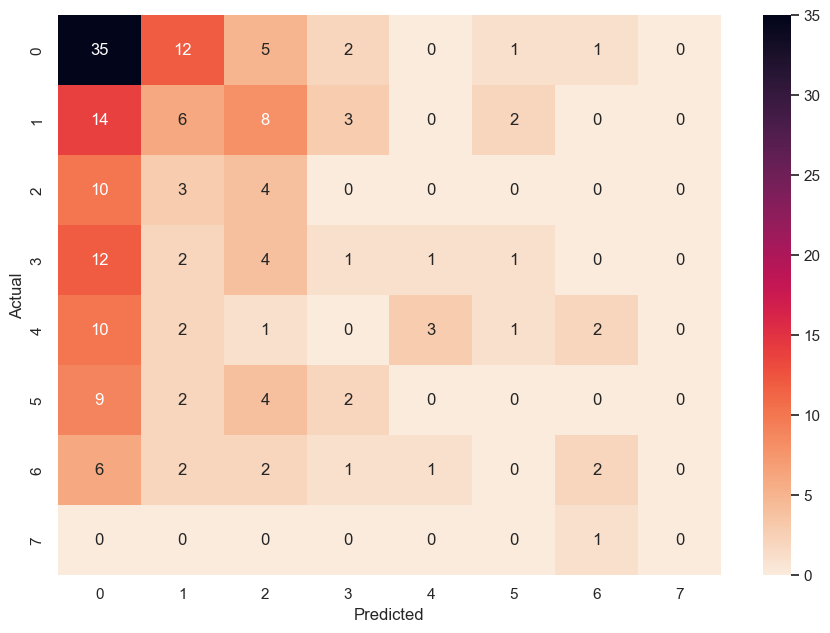

In [147]:

cm = confusion_matrix(y_test, y_pred)

sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.heatmap(cm, annot=True, cmap = 'rocket_r', fmt = '.20g')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [148]:
capture = np.eye(cm.shape[0], cm.shape[1]) + np.eye(cm.shape[0], cm.shape[1], k=-1)
print(f'Hit rate: {round((cm*capture).sum()/cm.sum()*100, 1)}%')

Hit rate: 41.0%
